# Prediction - Practice

This tutorial demonstrates how to build a predictive model to estimate household living standards in India for 2015 and 2019, using widely available geospatial predictors, such as nightlight intensity, population density, and urbanisation levels. The target variable is drawn from the Demographic and Health Surveys (DHS) and consists of sample-weighted standardised cluster-level observations of households' wealth index.

**Data description:**

| Variable     | Source   | Format | Resolution | Description                      |
|--------------|----------|--------|------------|----------------------------------|
| wealth       | DHS      | GPKG   | –          | Survey-weighted wealth index     |  
| states       | UN       | TIFF   | 1 km       | State identifiers                |
| nightlights  | VIIRS    | TIFF   | 1 km       | Log average nightlight radiance  |
| population   | WorldPop | TIFF   | 1 km       | Log population count             |
| settlements  | GHS SMOD | TIFF   | 1 km       | Recoded: 1=rural, 2=town, 3=city |

**Note:**
The DHS provides cluster-level georeferenced data, but the GPS coordinates randomly shifted for confidentiality. The shift is up to 2 km for "urban" clusters and up to 5 km for "rural" clusters. The UN boundaries include contested areas in a separate file.

In [2]:
# Packages
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import shutil
import statsmodels.api as sm
import os
import patsy

from tqdm import tqdm
from scipy import ndimage
from skimage import morphology
from sklearn import linear_model, metrics, model_selection, utils
from urllib import request

# Utilities
def download_data():
    '''Downloads the data folder'''
    if os.getcwd().endswith('/data'):
        print('Data folder already exists')
    else:
        request.urlretrieve('https://www.dropbox.com/scl/fo/izalz55go16wrdkbrtm4r/AAdkZqT0ug-pfwLR3SqBr3Q?rlkey=hgfxrz3ca2xgfiwuxjju5a1lx&dl=1', 'data.zip')
        shutil.unpack_archive('data.zip', 'data')
        os.remove('data.zip')
        os.chdir('data')

def read_raster(srcfile:str, band:int=1, nodata=-9999) -> np.ndarray:
    '''Reads a raster as a numpy array'''
    with rasterio.open(srcfile) as src:
        raster = src.read(band).astype(float)  # ensure float for NaNs
    raster = np.where(raster == nodata, np.nan, raster)
    return raster

def write_raster(array:np.ndarray, profile, dstfile:str, update:dict=None) -> None:
    '''Writes a numpy array as a raster'''
    if array.ndim == 2:
        array = np.expand_dims(array, axis=0)
    profile = rasterio.open(profile).profile
    if update is not None:
        profile.update(**update)
    with rasterio.open(fp=dstfile, mode='w', **profile) as raster:
        raster.write(array)
        raster.close()

def plot_raster(array: np.ndarray, title:str='', cmap:str='magma') -> None:
    '''Plots a raster array'''
    if array.ndim > 2:
        array = array[0]
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(array, cmap=cmap)
    fig.colorbar(im, ax=ax)
    ax.set_title(title, fontsize=15)
    ax.axis('off')
    plt.show()
    plt.close()

def plot_geopandas(gdf:gpd.GeoDataFrame, column:str=None, title:str='', cmap:str='magma', markersize:int=1) -> None:
    '''Plots a GeoDataFrame'''
    fig, ax = plt.subplots(figsize=(5, 5))
    gdf.plot(column=column, cmap=cmap, markersize=markersize, legend=True, ax=ax)
    ax.set_title(title, fontsize=15)
    ax.axis('off')
    plt.show()
    plt.close()

**Downloads the data**

In [3]:
# Execute on first run
download_data()

1. **Load data**

- Load the `wealth` dataset for year 2015 using `gpd.read_file`.
- Load the `nightlights`, `population` and `settlements` rasters for year 2015 using the provided `read_raster` function.

In [23]:
wealth = gpd.read_file('/Users/eduardo/Desktop/Applied-Data-Science-Classes/Deep Learning/data/wealth_india_2015.gpkg')
nightlights = read_raster('/Users/eduardo/Desktop/Applied-Data-Science-Classes/Deep Learning/data/nightlights_india_2015.tif')
settlements = read_raster('/Users/eduardo/Desktop/Applied-Data-Science-Classes/Deep Learning/data/settlements_india_2015.tif')
population = read_raster('/Users/eduardo/Desktop/Applied-Data-Science-Classes/Deep Learning/data/population_india_2015.tif')

2. **Descriptive statistics: Response**

- Visualise the first rows of the `wealth_index` dataset using the `head` method.
- Compute descriptive statistics for the `wealth_index` variable using the `describe` method.
- Compute frequencies for the categorical variables `state` and `urban_cluster` using the `value_counts` method.
- Visualise the cluster locations using the provided `plot_geopandas` function.

In [10]:
print(wealth_2015.head(1))
print(wealth_2015.describe())
print(wealth_2015['state'].value_counts())
print(wealth_2015['urban_cluster'].value_counts())

   cluster_id  n_households  urban_cluster           state  state_id  \
0       20001            22          False  andhra pradesh         1   

   wealth_index                         geometry  
0      0.342995  POINT (3753394.954 2962623.739)  
          cluster_id  n_households      state_id  wealth_index
count   27944.000000  27944.000000  27944.000000  27944.000000
mean   205401.189629     21.091361     19.002219      0.001641
std    102331.605496      1.355207     10.017145      0.793144
min     20001.000000      1.000000      1.000000     -1.792713
25%    130182.750000     21.000000     11.000000     -0.628779
50%    200596.500000     21.000000     19.000000     -0.082156
75%    300141.250000     22.000000     28.000000      0.613096
max    360482.000000     28.000000     34.000000      2.238090
state
uttar pradesh                         3624
madhya pradesh                        2412
bihar                                 1661
rajasthan                             1630
odisha  

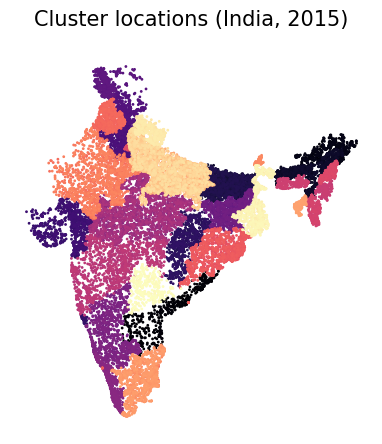

In [41]:
plot_geopandas(
    gdf=wealth_2015,
    column=None,
    title="Cluster locations (India, 2015)",
)

3. **Descriptive statistics: Inputs**

- Visualise the `nightlights`, `population` and `settlements` rasters using the provided `plot_raster` function.
- Check the dimensions of the `nightlights`, `population` and `settlements` using the `shape` method and compute descriptive statistics.

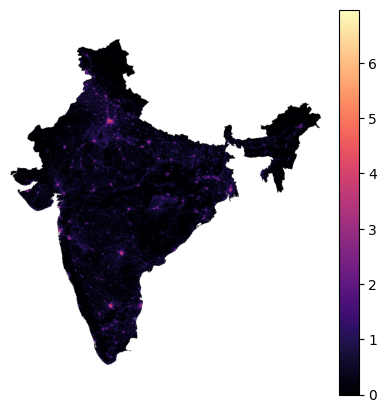

(3008, 2861)

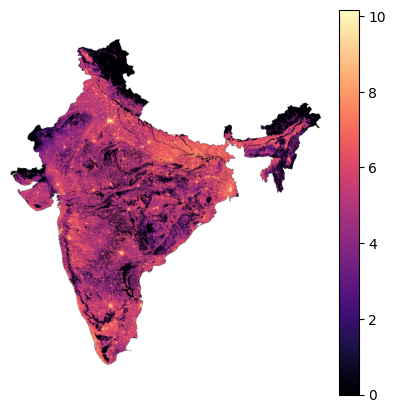

(3008, 2861)

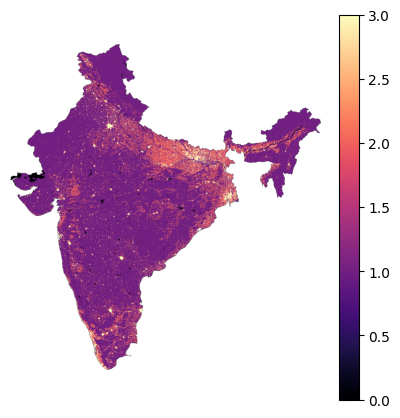

(3008, 2861)

In [17]:
plot_raster(nightlights_2015)
display(nightlights_2015.shape)
plot_raster(population_2015)
display(population_2015.shape)
plot_raster(settlements_2015)
display(settlements_2015.shape)

4. **Extracting raster values**

This code extracts raster values for `nightlights`, `population`, and `settlements` at the cluster coordinates and appends them to the dataset. Because DHS coordinates are randomly displaced (up to 2 km in urban areas and 5 km in rural areas), the code computes average values within 2 km and 5 km buffers, respectively. For simplicity, the `settlements` raster is converted into a binary variable, `urban_area`. For the remainder of this exercise, use the computed `dataset` containing the relevant variables.

**Note:** The answers to this question are provided, as well as the resulting dataset `dataset_india_2015.csv`.

In [24]:
# Urban area binary variable
urban_areas = np.where(np.isnan(settlements), np.nan, settlements == 3)

# Extracts affine transform mapping geographic coordinates to pixel coordinates
with rasterio.open('grid_india.tif') as src:
    transform = src.transform

def sample_array(array:np.ndarray, gdf:gpd.GeoDataFrame, transform:rasterio.Affine) -> np.ndarray:
    '''Samples raster values at point locations'''
    cols, rows = np.round([~transform * (coord.x, coord.y) for coord in gdf.geometry]).astype(int).T
    mask   = ((rows >= 0) & (rows < array.shape[0]) & (cols >= 0) & (cols < array.shape[1]))
    values = np.full(len(rows), np.nan)
    values[mask] = array[rows[mask], cols[mask]]
    return values

dataset = wealth.drop(columns=['n_households', 'urban_cluster', 'geometry'])

'''
# Extracts raster values without spatial smoothing
for var, name in zip([nightlights, population, urban_areas], ['nightlights', 'population', 'urban_areas']):
    dataset[name] = sample_array(array=var, gdf=wealth, transform=transform)
'''

# Extracts raster values with spatial smoothing
for var, name in zip([nightlights, population, urban_areas], ['nightlights', 'population', 'urban_areas']):
    smooth = dict()
    for dist in [2, 5]:
        kernel = morphology.disk(dist)
        values = ndimage.convolve(input=np.nan_to_num(var, nan=0.0), weights=kernel / kernel.sum(), mode='constant', cval=0.0)
        values = sample_array(array=values, gdf=wealth, transform=transform)
        smooth[f'{dist}k'] = values
    dataset[name] = np.where(wealth['urban_cluster'], smooth['2k'], smooth['5k'])

dataset['urban_areas'] = dataset['urban_areas'] > 0.5
del var, name, smooth, dist, kernel, values

5. **Training and test samples** 

Randomly partition the observations into a training sample (75%) and a test sample (25%) using `model_selection.train_test_split`. Specify a seed using the `random_state` argument to make your results reproductible.

In [25]:
random_state = 42
dataset = pd.read_csv('/Users/eduardo/Desktop/Applied-Data-Science-Classes/Deep Learning/data/dataset_india_2015.csv')
from sklearn.model_selection import train_test_split

# 1) Define target and predictors
y = dataset["wealth_index"]
X = dataset[["nightlights", "population", "urban_areas"]]

# Optional but recommended: drop missing rows
data = pd.concat([X, y], axis=1).dropna()
X = data[["nightlights", "population", "urban_areas"]]
y = data["wealth_index"]

# 2) Split: 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)

# Sanity check
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(20958, 3) (6986, 3)
(20958,) (6986,)


6. **Estimation**

- Fit a linear model to the training sample using `linear_model.LinearRegression()`. 
- Extract the estimated parameters using the `coef_` method of the model.
- Interpret the sign, magnitude and significance of estimated coefficients. 

**Note:** For econometrics-style regression tables, you can also use the `statsmodels` package.

In [28]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

coef = pd.Series(linreg.coef_, index=X_train.columns)

print(linreg.intercept_)
print(coef)

-0.4282293068085481
nightlights    0.486123
population     0.004344
urban_areas    0.036801
dtype: float64


**7. Model performance**

- Compute the predicted `wealth_index` for the training and the test samples.
- Assess the model's performance on each sample using `metrics.mean_squared_error`.
- Compute the cross-validated error using `model_selection.cross_validate` with 100 folds and the scoring method `neg_mean_squared_error`.

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, KFold

# 1) Predictions
yhat_train = linreg.predict(X_train)
yhat_test  = linreg.predict(X_test)

# 2) Performance: MSE on train and test
mse_train = mean_squared_error(y_train, yhat_train)
mse_test  = mean_squared_error(y_test, yhat_test)

print(f"Train MSE: {mse_train:.4f}")
print(f"Test  MSE: {mse_test:.4f}")

# 3) Cross-validated error (100 folds) on the training sample
cv = KFold(n_splits=100, shuffle=True, random_state=42)

cv_out = cross_validate(
    linreg,
    X_train,
    y_train,
    cv=cv,
    scoring="neg_mean_squared_error",
    return_train_score=False
)

# cross_validate returns negative MSE by convention; convert back
cv_mse = -cv_out["test_score"]
print(f"CV MSE (mean over 100 folds): {cv_mse.mean():.4f}")
print(f"CV MSE (std  over 100 folds): {cv_mse.std():.4f}")

Train MSE: 0.4026
Test  MSE: 0.4020
CV MSE (mean over 100 folds): 0.4028
CV MSE (std  over 100 folds): 0.0388


**8. Prediction**

- Create a `dataset` containing the predictors for all observations.
- Using your estimated model, predict the `wealth_index` for the entire country.
- Visualise the resuts using the provided `plot_raster` function.

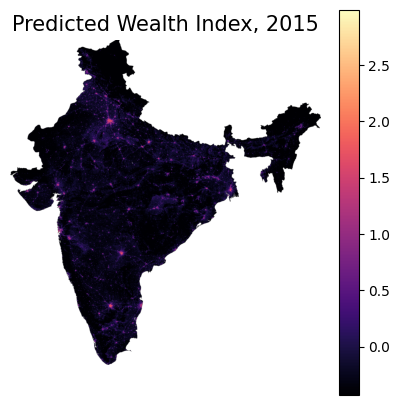

In [34]:
# --- Urban binary variable from settlements (city == 3) ---
urban_areas = np.where(np.isnan(settlements), np.nan, settlements == 3).astype(float)

# --- Build pixel-level predictor matrix ---
X_all = pd.DataFrame({
    "nightlights": nightlights.ravel(),
    "population":  population.ravel(),
    "urban_areas": urban_areas.ravel()
})

# Mask valid pixels (no NaNs in predictors)
mask = X_all.notna().all(axis=1)

# Predict only where predictors are valid
yhat_all = np.full(X_all.shape[0], np.nan)
yhat_all[mask] = linreg.predict(X_all.loc[mask])

# Reshape back to raster grid
wealth_pred = yhat_all.reshape(nightlights.shape)

# --- Visualize ---
plot_raster(wealth_pred, title="Predicted Wealth Index, 2015")

**9. Modelling approach**

- Comment on the relevance of the model choice.
- Which other predictors would you use?

**BONUS (intermediate)**. Replicate the analysis by modelling changes between 2015 and 2020. Note that the `wealth_index` variable is standardised separately for each wave and therefore not directly comparable across waves.

In [35]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from scipy import ndimage
from skimage import morphology
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

BASE = "/Users/eduardo/Desktop/Applied-Data-Science-Classes/Deep Learning/data"

def build_dataset(year: int) -> pd.DataFrame:
    # Load cluster wealth points
    wealth = gpd.read_file(f"{BASE}/wealth_india_{year}.gpkg")

    # Load rasters
    nightlights = read_raster(f"{BASE}/nightlights_india_{year}.tif")
    population  = read_raster(f"{BASE}/population_india_{year}.tif")
    settlements = read_raster(f"{BASE}/settlements_india_{year}.tif")

    # Urban (city==3) as float raster with NaNs preserved
    urban_areas = np.where(np.isnan(settlements), np.nan, settlements == 3).astype(float)

    # Affine transform from grid
    with rasterio.open(f"{BASE}/grid_india.tif") as src:
        transform = src.transform

    def sample_array(array: np.ndarray, gdf: gpd.GeoDataFrame, transform: rasterio.Affine) -> np.ndarray:
        cols, rows = np.round([~transform * (coord.x, coord.y) for coord in gdf.geometry]).astype(int).T
        mask = ((rows >= 0) & (rows < array.shape[0]) & (cols >= 0) & (cols < array.shape[1]))
        values = np.full(len(rows), np.nan)
        values[mask] = array[rows[mask], cols[mask]]
        return values

    # Create dataset
    dataset = wealth.drop(columns=["n_households", "geometry"])  # keep urban_cluster for smoothing rule
    # Add smoothed predictors (2km if urban_cluster else 5km)
    for var, name in zip([nightlights, population, urban_areas], ["nightlights", "population", "urban_areas"]):
        smooth = {}
        for dist in [2, 5]:
            kernel = morphology.disk(dist)
            values = ndimage.convolve(
                input=np.nan_to_num(var, nan=0.0),
                weights=kernel / kernel.sum(),
                mode="constant",
                cval=0.0
            )
            values = sample_array(array=values, gdf=wealth, transform=transform)
            smooth[f"{dist}k"] = values

        dataset[name] = np.where(dataset["urban_cluster"], smooth["2k"], smooth["5k"])

    # Make urban_areas boolean (like tutorial)
    dataset["urban_areas"] = dataset["urban_areas"] > 0.5

    return dataset


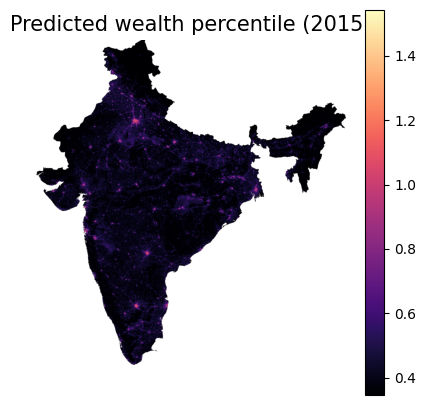

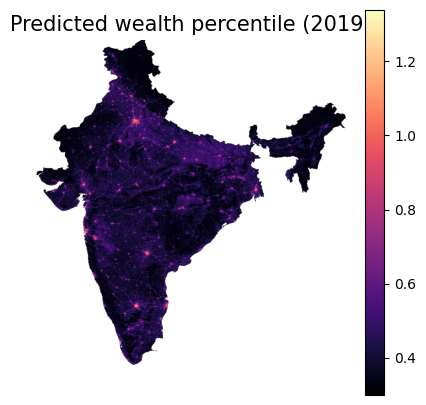

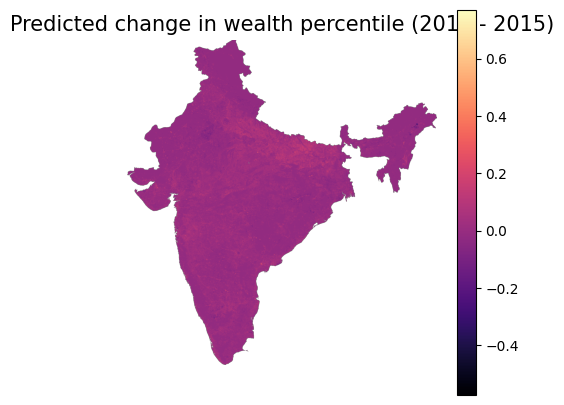

In [36]:
# Build both waves
data_2015 = build_dataset(2015)
data_2019 = build_dataset(2019)

# Convert wealth_index to within-wave percentile rank (0..1), comparable across waves
data_2015["wealth_rank"] = data_2015["wealth_index"].rank(pct=True)
data_2019["wealth_rank"] = data_2019["wealth_index"].rank(pct=True)

# Predictors
Xcols = ["nightlights", "population", "urban_areas"]

# Train separate models for each wave (same feature set)
train_2015 = data_2015[Xcols + ["wealth_rank"]].dropna()
train_2019 = data_2019[Xcols + ["wealth_rank"]].dropna()

X15, y15 = train_2015[Xcols], train_2015["wealth_rank"]
X19, y19 = train_2019[Xcols], train_2019["wealth_rank"]

m15 = LinearRegression().fit(X15, y15)
m19 = LinearRegression().fit(X19, y19)

# Build national pixel-level predictors for each year (for mapping)
nightlights_2015 = read_raster(f"{BASE}/nightlights_india_2015.tif")
population_2015  = read_raster(f"{BASE}/population_india_2015.tif")
settlements_2015 = read_raster(f"{BASE}/settlements_india_2015.tif")
urban_areas_2015 = np.where(np.isnan(settlements_2015), np.nan, settlements_2015 == 3).astype(float)

nightlights_2019 = read_raster(f"{BASE}/nightlights_india_2019.tif")
population_2019  = read_raster(f"{BASE}/population_india_2019.tif")
settlements_2019 = read_raster(f"{BASE}/settlements_india_2019.tif")
urban_areas_2019 = np.where(np.isnan(settlements_2019), np.nan, settlements_2019 == 3).astype(float)

def predict_map(model, nightlights, population, urban_areas) -> np.ndarray:
    X_all = pd.DataFrame({
        "nightlights": nightlights.ravel(),
        "population":  population.ravel(),
        "urban_areas": urban_areas.ravel() > 0.5
    })
    mask = X_all.notna().all(axis=1)
    yhat = np.full(X_all.shape[0], np.nan)
    yhat[mask] = model.predict(X_all.loc[mask, Xcols])
    return yhat.reshape(nightlights.shape)

pred_rank_2015 = predict_map(m15, nightlights_2015, population_2015, urban_areas_2015)
pred_rank_2019 = predict_map(m19, nightlights_2019, population_2019, urban_areas_2019)

# Change in predicted percentile rank (positive = improved relative standing)
pred_change = pred_rank_2019 - pred_rank_2015

# Visualize
plot_raster(pred_rank_2015, title="Predicted wealth percentile (2015)")
plot_raster(pred_rank_2019, title="Predicted wealth percentile (2019)")
plot_raster(pred_change, title="Predicted change in wealth percentile (2019 - 2015)")


In [37]:
write_raster(
    array=pred_change,
    profile=f"{BASE}/grid_india.tif",
    dstfile=f"{BASE}/predicted_change_wealth_percentile_2019_minus_2015.tif"
)

**BONUS (advanced)**. Use `utils.resample` to generate 1,000 bootstrap samples (with replacement), each of the same size as the original dataset. Compute the 95% confidence and prediction intervals. Plot the results and comment on the model's predictive performance.

In [38]:
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Use 2015 wealth_index (your original task)
data = build_dataset(2015).dropna(subset=["wealth_index", "nightlights", "population", "urban_areas"])

X = data[Xcols]
y = data["wealth_index"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

base_model = LinearRegression().fit(X_train, y_train)
yhat_test = base_model.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, yhat_test))

Test MSE: 0.4020147294683972


In [39]:
B = 1000
rng = np.random.RandomState(42)

pred_boot = np.zeros((B, len(X_test)))      # mean prediction draws
pred_boot_pi = np.zeros((B, len(X_test)))   # prediction draws incl. noise

Xtr = X_train.reset_index(drop=True)
ytr = y_train.reset_index(drop=True)

for b in range(B):
    # Resample training data with replacement
    Xb, yb = resample(Xtr, ytr, replace=True, n_samples=len(Xtr), random_state=rng.randint(0, 10**9))

    # Fit model on bootstrap sample
    mb = LinearRegression().fit(Xb, yb)

    # Mean predictions on test set
    yhat_b = mb.predict(X_test)
    pred_boot[b, :] = yhat_b

    # Residuals on bootstrap sample (for prediction intervals)
    resid_b = yb - mb.predict(Xb)

    # Add sampled residual noise to each test prediction
    noise = rng.choice(resid_b, size=len(X_test), replace=True)
    pred_boot_pi[b, :] = yhat_b + noise

# 95% CI for mean prediction
ci_low  = np.percentile(pred_boot, 2.5, axis=0)
ci_high = np.percentile(pred_boot, 97.5, axis=0)

# 95% PI for new observation
pi_low  = np.percentile(pred_boot_pi, 2.5, axis=0)
pi_high = np.percentile(pred_boot_pi, 97.5, axis=0)

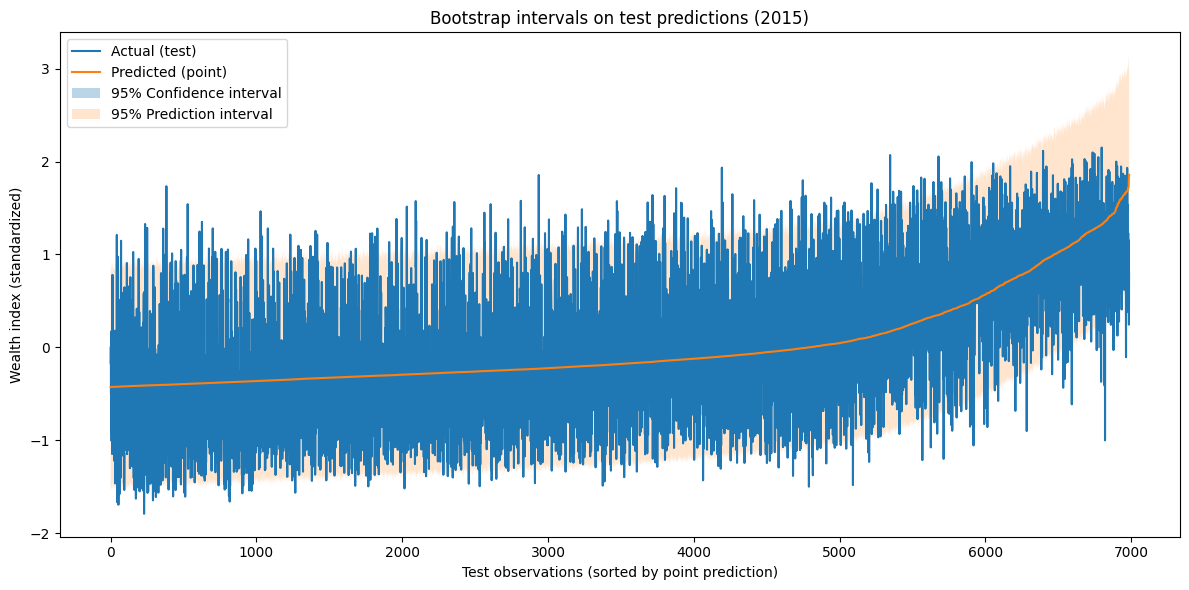

In [40]:
order = np.argsort(yhat_test)
y_test_s = np.array(y_test)[order]
yhat_s   = np.array(yhat_test)[order]

ci_low_s, ci_high_s = ci_low[order], ci_high[order]
pi_low_s, pi_high_s = pi_low[order], pi_high[order]

plt.figure(figsize=(12, 6))
plt.plot(y_test_s, label="Actual (test)")
plt.plot(yhat_s, label="Predicted (point)")

# Shaded intervals
plt.fill_between(np.arange(len(yhat_s)), ci_low_s, ci_high_s, alpha=0.3, label="95% Confidence interval")
plt.fill_between(np.arange(len(yhat_s)), pi_low_s, pi_high_s, alpha=0.2, label="95% Prediction interval")

plt.title("Bootstrap intervals on test predictions (2015)")
plt.xlabel("Test observations (sorted by point prediction)")
plt.ylabel("Wealth index (standardized)")
plt.legend()
plt.tight_layout()
plt.show()